In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats
from skimage import filters
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage
from typing import List, Tuple, Dict

In [2]:
# Define folder that contains the dhg dataset
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dhg images
DHG_IN_PATH = f"{DHG_PATH}/preprocessed"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"

In [3]:
# read metadata csv
metadata_df = pd.read_csv(METADATA_PATH)

In [4]:
# Create dict's to store each sample spectra's sum and count
# for tissue and non tissue spectra's
tissue_spectras_sum = {}
tissue_spectras_count = {}
non_tissue_spectras_sum = {}
non_tissue_spectras_count = {}

# Define object to store common mz values
mzs = None

# Loop over each sample
for _, row in metadata_df.iterrows():
  # Parse the sample file
  with ImzMLParser(os.path.join(DHG_IN_PATH,
                                f"{row.sample_file_name}.imzML")) as reader:
    # Get local TIC image of sample in mz region [600, 900]
    local_tic_img = getionimage(reader, 750, tol=150)

    # Threshold image to separate tissue spectra from background
    thresh_img = local_tic_img > filters.threshold_mean(local_tic_img)

    # Loop over each spectra
    for idx, (x, y, z) in enumerate(reader.coordinates):
      # Get mzs and spectra
      mzs, intensities = reader.getspectrum(idx)

      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Add spectra
        tissue_spectras_sum[row.sample_file_name] = tissue_spectras_sum.get(
            row.sample_file_name, 0) + intensities
        tissue_spectras_count[row.sample_file_name] = tissue_spectras_count.get(
            row.sample_file_name, 0) + 1
      else:
        # Add spectra
        non_tissue_spectras_sum[
            row.sample_file_name] = non_tissue_spectras_sum.get(
                row.sample_file_name, 0) + intensities
        non_tissue_spectras_count[
            row.sample_file_name] = non_tissue_spectras_count.get(
                row.sample_file_name, 0) + 1

# Calculate mean spectra for each image
tissue_spectras_mean = {
    key: (tissue_spectras_sum[key] / tissue_spectras_count[key])
    for key in tissue_spectras_sum.keys()
}
non_tissue_spectras_mean = {
    key: (non_tissue_spectras_sum[key] / non_tissue_spectras_count[key])
    for key in tissue_spectras_sum.keys()
}

In [5]:
def corr(i_keys: List[str],
         j_keys: List[str],
         i_vals: Dict[str, np.ndarray],
         j_vals: Dict[str, np.ndarray],
         corr_type: str = "pearson") -> pd.DataFrame:
  """Function to calculate correlation matrix

  Args:
      i_keys (List[str]):  Matrix i (rows) keys.
      j_keys (List[str]): Matrix i (columns) keys.
      i_vals (Dict[str, np.ndarray]): Dict with keys corresponding to i_keys
        and values of the keys.
      j_vals (Dict[str, np.ndarray]): Dict with keys corresponding to j_keys
        and values of the keys.
      corr_type (str, optional): Correlation type . Defaults to "pearson".
      

  Returns:
      pd.DataFrame: Correlation matrix where index is i_keys and columns are
        j_keys and each cell [i_key, j_key] is the correlation between i_val
        and j_val.

  """
  # Create empty correlation matrix
  corr_m = np.zeros((len(i_keys), len(j_keys)))
  # Loop over i keys
  for idx_i, key_i in enumerate(i_keys):
    # Loop over j keys
    for idx_j, key_j in enumerate(j_keys):
      # Calculate corelation between i_val and j_val
      if corr_type == "kendall":
        corr_m[idx_i, idx_j] = stats.kendalltau(i_vals[key_i], j_vals[key_j])[0]
      elif corr_type == "spearman":
        corr_m[idx_i, idx_j] = stats.spearmanr(i_vals[key_i], j_vals[key_j])[0]
      else:
        corr_m[idx_i, idx_j] = stats.pearsonr(i_vals[key_i], j_vals[key_j])[0]
  # return correlation data frame
  return pd.DataFrame(corr_m, index=i_keys, columns=j_keys)

### ***Tissue2Tissue correlation Section2Section:***

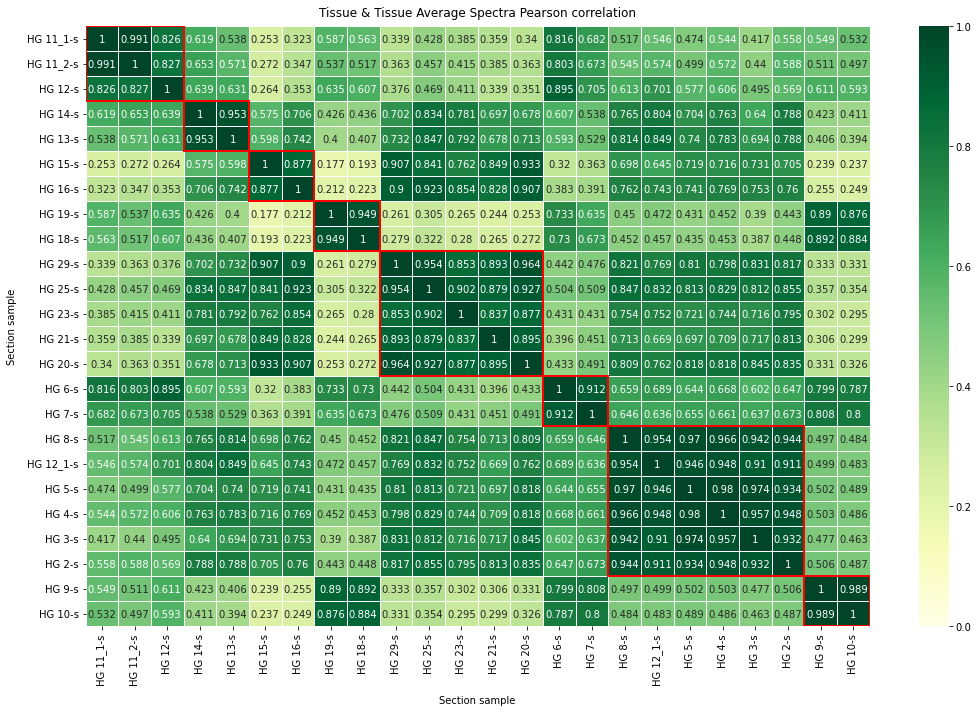

In [36]:
# Create correlation data frame
s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, s_sample_file_name, tissue_spectras_mean,
                tissue_spectras_mean)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Tissue & Tissue Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Section sample", labelpad=10)
ax.set_xlabel(f"Section sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "section"].groupby('file_name'):
  start_i = s_sample_file_name[s_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = s_sample_file_name[s_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***NonTissue2NonTissue correlation Section2Section:***

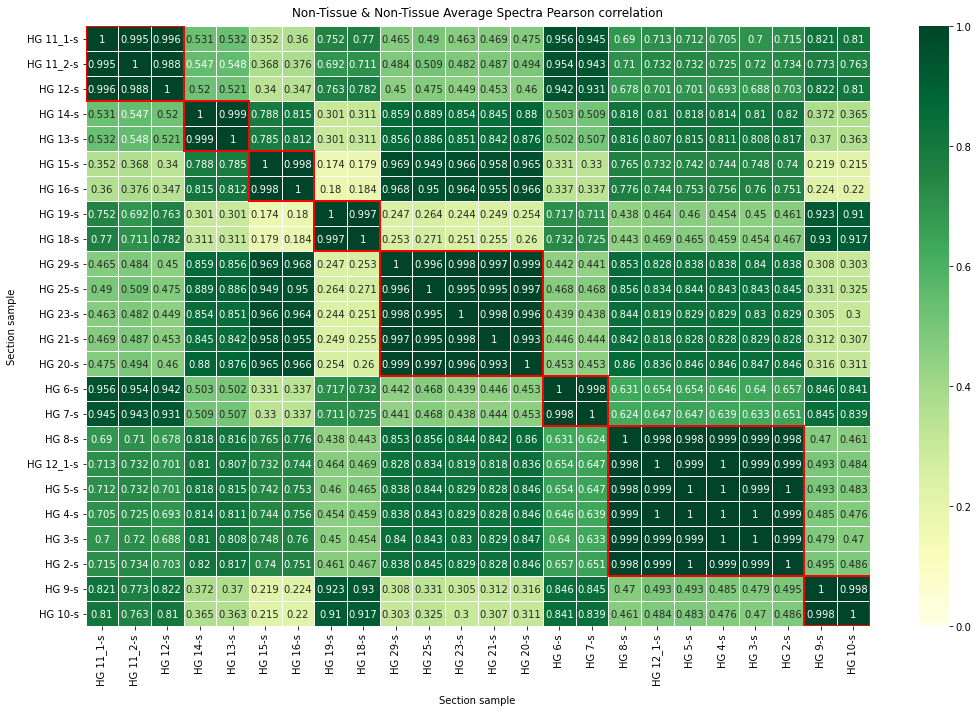

In [37]:
# Create correlation data frame
s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, s_sample_file_name, non_tissue_spectras_mean,
                non_tissue_spectras_mean)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Non-Tissue & Non-Tissue Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Section sample", labelpad=10)
ax.set_xlabel(f"Section sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "section"].groupby('file_name'):
  start_i = s_sample_file_name[s_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = s_sample_file_name[s_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***Tissue2NonTissue correlation Section2Section:***

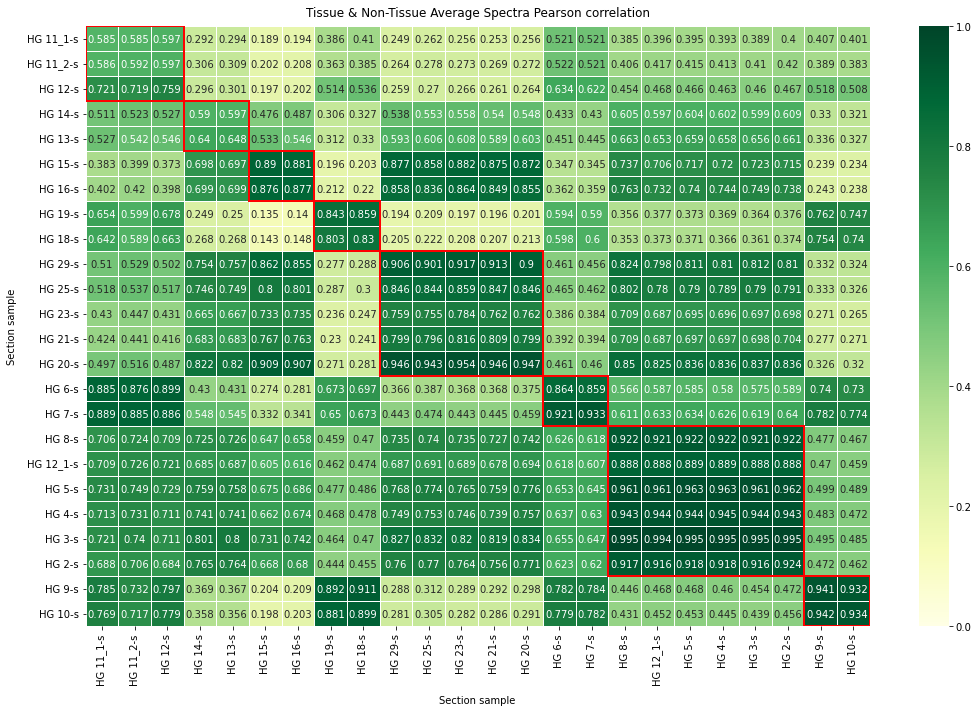

In [38]:
# Create correlation data frame
s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, s_sample_file_name, tissue_spectras_mean,
                non_tissue_spectras_mean)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Tissue & Non-Tissue Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Section sample", labelpad=10)
ax.set_xlabel(f"Section sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "section"].groupby('file_name'):
  start_i = s_sample_file_name[s_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = s_sample_file_name[s_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***Tissue2Tissue correlation Replica2Replica:***

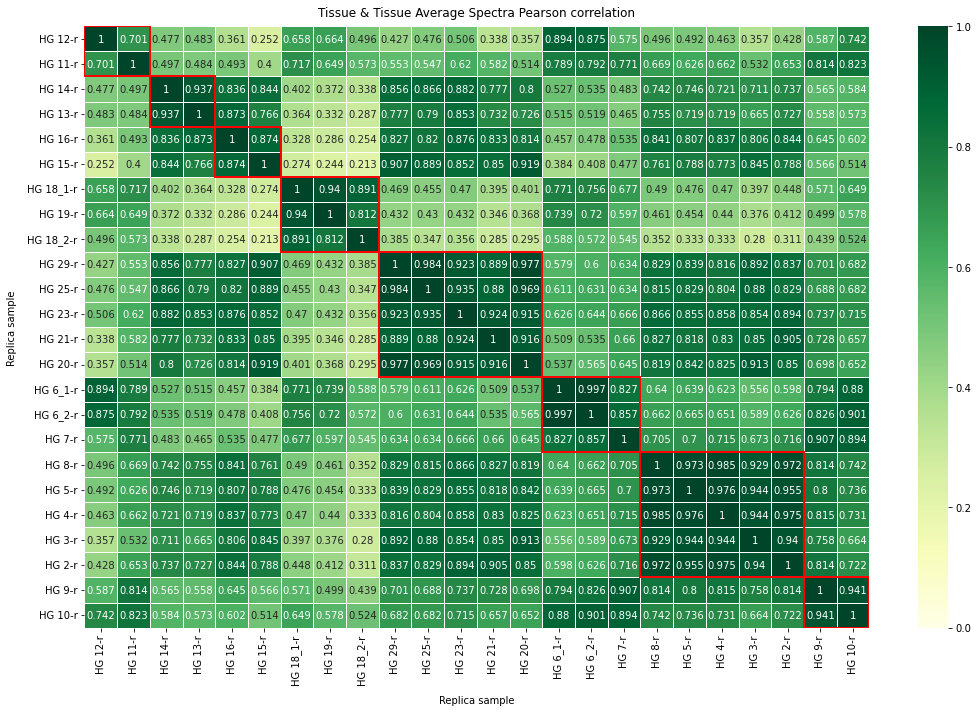

In [39]:
# Create correlation data frame
r_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)

corr_df = corr(r_sample_file_name, r_sample_file_name, tissue_spectras_mean,
                tissue_spectras_mean)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Tissue & Tissue Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Replica sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "replica"].groupby('file_name'):
  start_i = r_sample_file_name[r_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = r_sample_file_name[r_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***NonTissue2NonTissue correlation Replica2Replica:***

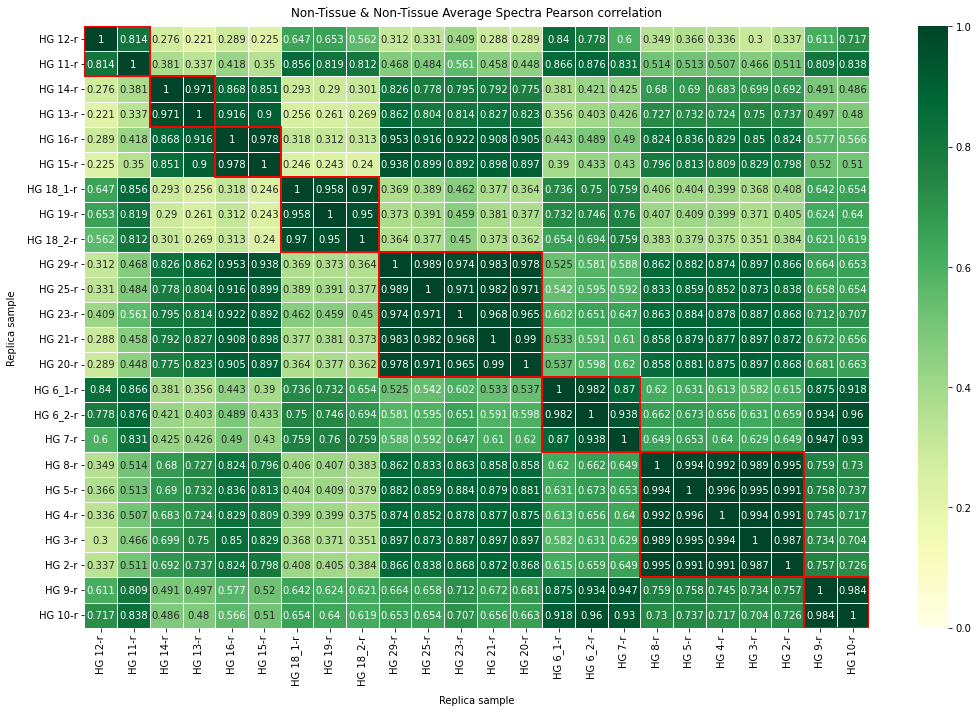

In [40]:
# Create correlation data frame
r_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)

corr_df = corr(r_sample_file_name, r_sample_file_name, non_tissue_spectras_mean,
                non_tissue_spectras_mean)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Non-Tissue & Non-Tissue Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Replica sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "replica"].groupby('file_name'):
  start_i = r_sample_file_name[r_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = r_sample_file_name[r_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***Tissue2NonTissue correlation Replica2Replica:***

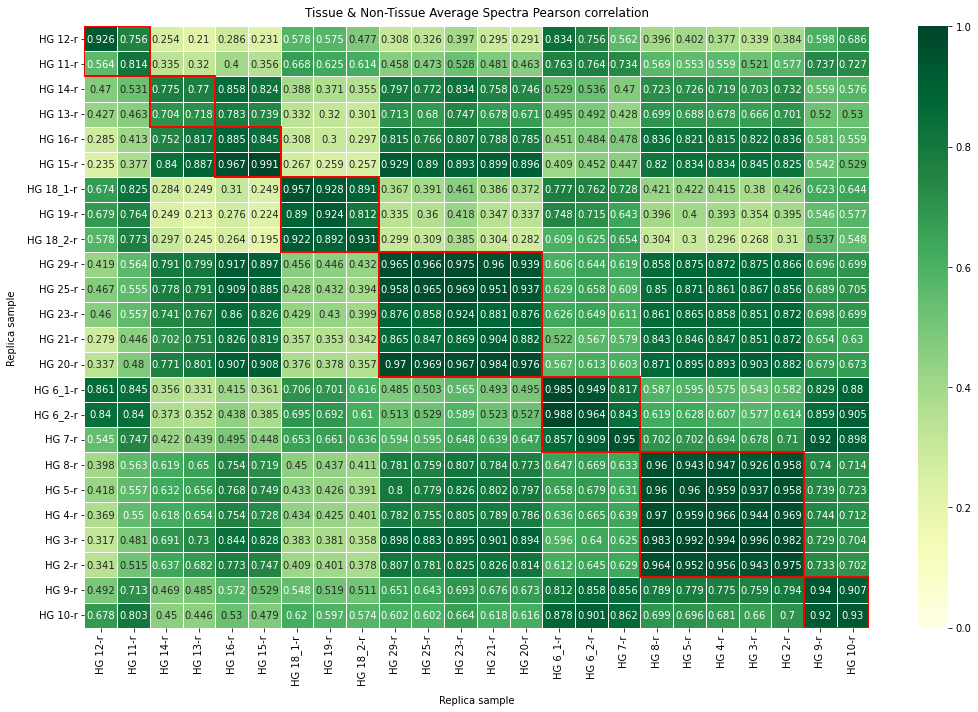

In [41]:
# Create correlation data frame
r_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)

corr_df = corr(r_sample_file_name, r_sample_file_name, tissue_spectras_mean,
                non_tissue_spectras_mean)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Tissue & Non-Tissue Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Replica sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "replica"].groupby('file_name'):
  start_i = r_sample_file_name[r_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = r_sample_file_name[r_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

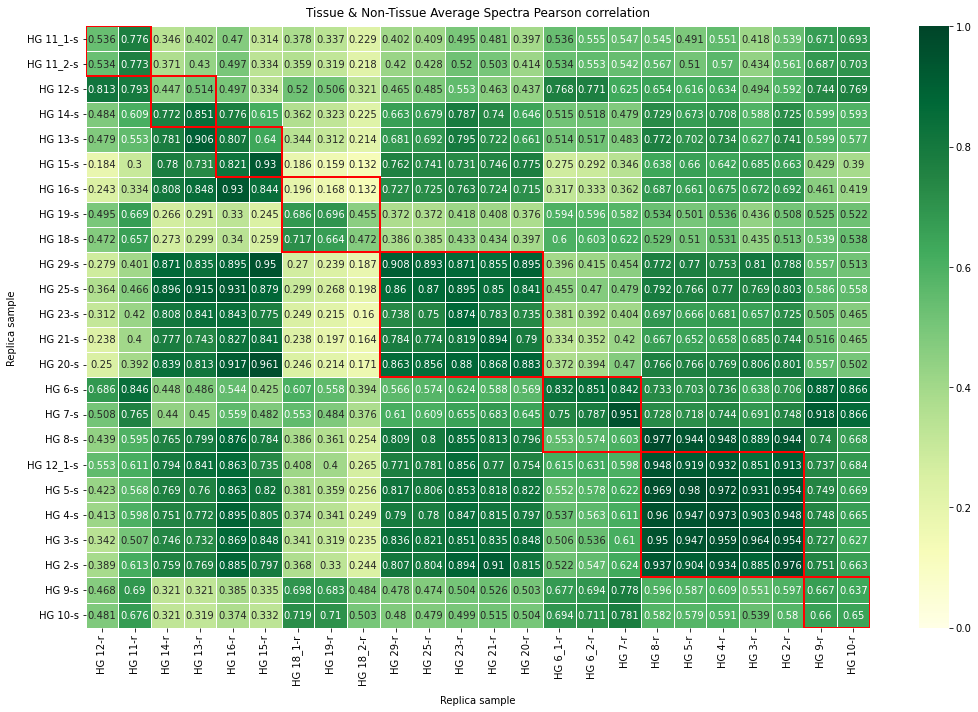

In [47]:
map_r_s = {
    'HG 12-11-r': 'HG 11-11-12-s',
    'HG 14-13-r': 'HG 14-13-s',
    'HG 16-15-r': 'HG 15-16-s',
    'HG 18-19-18-r': 'HG 19-18-s',
    'HG 29-25-23-21-20-r': 'HG 29-25-23-21-20-s',
    'HG 6-6-7-r': 'HG 6-7-s',
    'HG 8-12-5-4-3-2-s': 'HG 8-5-4-3-2-r',
    'HG 9-10-r': 'HG 9-10-s'
}

# Create correlation data frame
r_sample_file_name = metadata_df[metadata_df.sample_type ==
                                 "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)
s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                 "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, r_sample_file_name, tissue_spectras_mean,
               tissue_spectras_mean)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                 annot=True,
                 cmap="YlGn",
                 vmin=0,
                 vmax=1,
                 fmt=".3g",
                 linewidth=.5,
                 linecolor='w')
ax.set_title("Tissue & Tissue Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Section sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "replica"].groupby('file_name'):
  for group_name_2, df_group_2 in metadata_df[metadata_df.sample_type ==
                                              "replica"].groupby('file_name'):
    if map_r_s[group_name_2] == group_name:
      start_i = r_sample_file_name[r_sample_file_name ==
                                   df_group.iloc[0].sample_file_name].index[0]
      end_i = r_sample_file_name[r_sample_file_name ==
                                 df_group.iloc[-1].sample_file_name].index[0]
      span = end_i - start_i + 1
      ax.add_patch(
          Rectangle((start_i, start_i),
                    span,
                    span,
                    fill=False,
                    edgecolor="red",
                    lw=2))

# Show plot
plt.tight_layout()
plt.show()

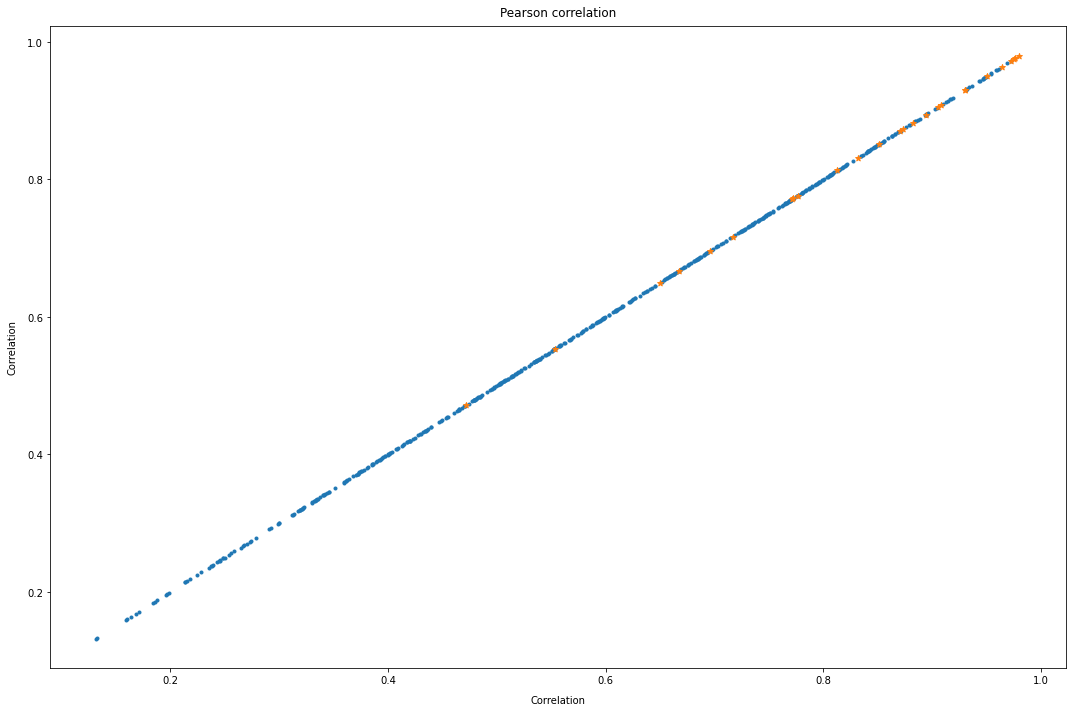

In [46]:
# Create correlation data frame
r_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)

s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, r_sample_file_name, tissue_spectras_mean,
                tissue_spectras_mean)

# Plot correlation data frame
map_s_f = pd.Series(metadata_df.sample_number.values,index=metadata_df.sample_file_name.values).to_dict()
pair_vals = []
non_pair_vals = []
for row_index, row in corr_df.iterrows():
    for column_index, val in row.items():
        if map_s_f[row_index] == map_s_f[column_index]:
            pair_vals.append(val)
        else:
            non_pair_vals.append(val)

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(non_pair_vals, non_pair_vals ,marker=".")
ax.scatter(pair_vals, pair_vals, marker="*")
ax.set_title("Pearson correlation", pad=10)
ax.set_ylabel(f"Correlation", labelpad=10)
ax.set_xlabel(f"Correlation", labelpad=10)


# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Create correlation data frame
s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "replica"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, s_sample_file_name, tissue_spectras_mean,
                tissue_spectras_mean)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Pearson correlation", pad=10)
ax.set_ylabel(f"Replica sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "replica"].groupby('file_name'):
  start_i = s_sample_file_name[s_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = s_sample_file_name[s_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

  # Show plot
  plt.tight_layout()
  plt.show()

### Section-Section & Replica-Replica non tissue correlation matrix:

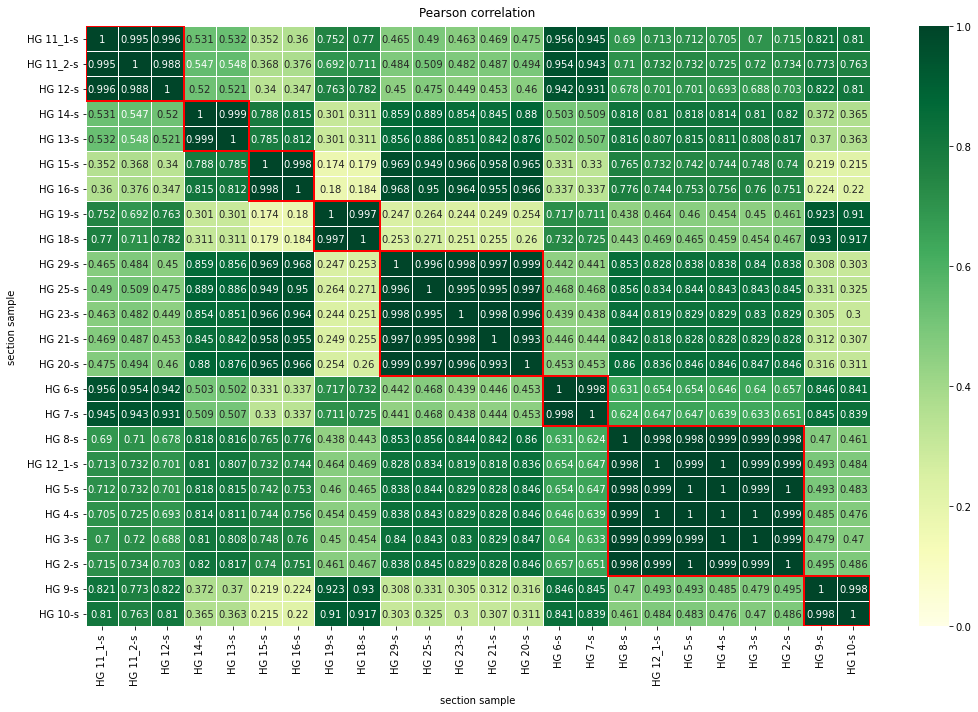

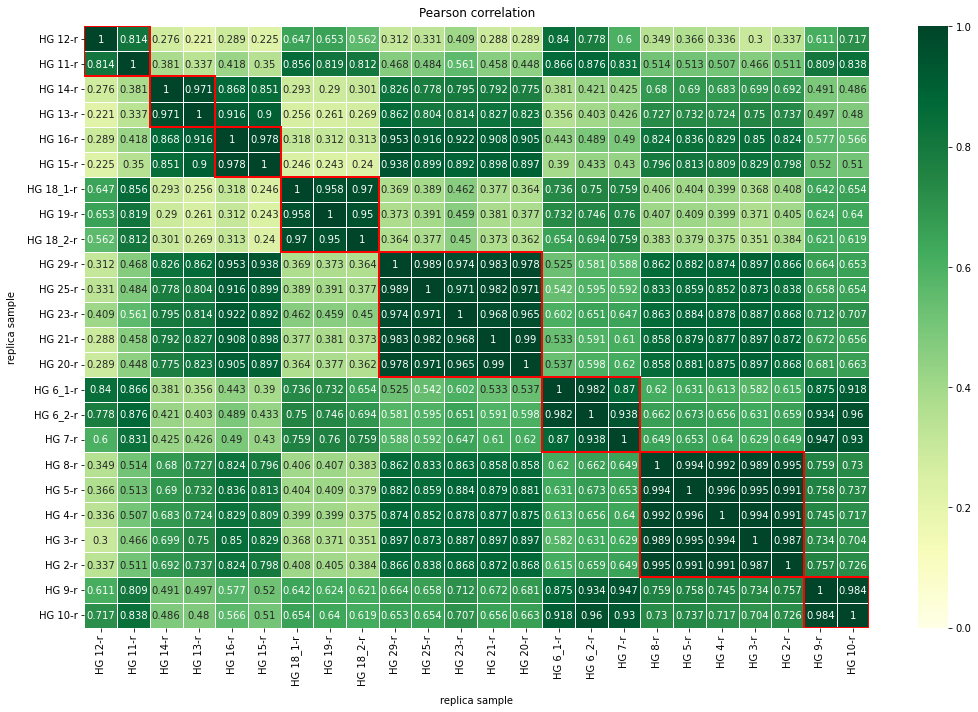

In [98]:
for s_type in metadata_df.sample_type.unique():
  # Create correlation data frame
  s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                   s_type].sample_file_name
  s_sample_file_name = s_sample_file_name.reset_index(drop=True)

  corr_df = corr(s_sample_file_name, s_sample_file_name,
                 non_tissue_spectras_mean, non_tissue_spectras_mean)

  # Plot correlation data frame
  ax = plot_corr(corr_df,
                 title="Pearson correlation",
                 x_label=f"{s_type} sample",
                 y_label=f"{s_type} sample")

  # Mark cells of sample in same image
  for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                          s_type].groupby('file_name'):
    start_i = s_sample_file_name[s_sample_file_name ==
                                 df_group.iloc[0].sample_file_name].index[0]
    end_i = s_sample_file_name[s_sample_file_name ==
                               df_group.iloc[-1].sample_file_name].index[0]
    span = end_i - start_i + 1
    ax.add_patch(
        Rectangle((start_i, start_i),
                  span,
                  span,
                  fill=False,
                  edgecolor="red",
                  lw=2))

  # Show plot
  plt.tight_layout()
  plt.show()

### Section-Replica tissue correlation matrix:

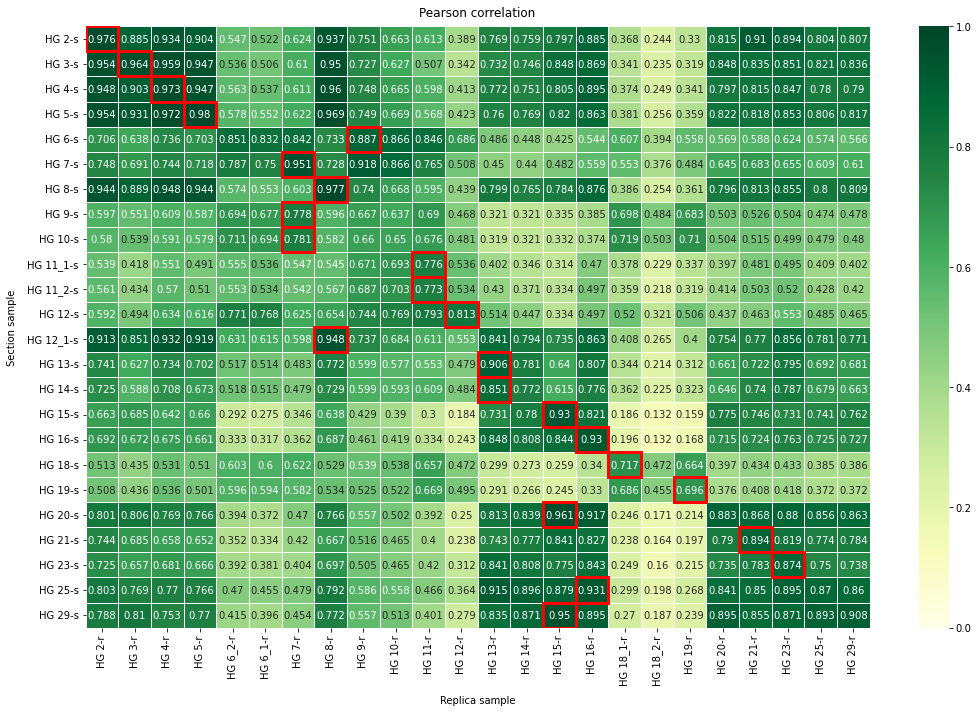

In [105]:
# Create correlation data frame
metadata_df_sort = metadata_df.sort_values(by="sample_number")
s_sample_file_name = metadata_df_sort[metadata_df_sort.sample_type ==
                                      "section"].sample_file_name
r_sample_file_name = metadata_df_sort[metadata_df_sort.sample_type ==
                                      "replica"].sample_file_name

corr_df = corr(s_sample_file_name, r_sample_file_name, tissue_spectras_mean,
               tissue_spectras_mean)

# Plot correlation data frame
ax = plot_corr(corr_df,
               title="Pearson correlation",
               x_label=f"Section sample",
               y_label=f"Replica sample")

# Mark cells of max correlation between section and replica
row_max = corr_df.idxmax(axis=1)
for row, index in enumerate(s_sample_file_name):
  position = corr_df.columns.get_loc(row_max[index])
  ax.add_patch(
      Rectangle((position, row), 1, 1, fill=False, edgecolor='red', lw=3))

# Show plot
plt.tight_layout()
plt.show()

### Section-Replica tissue correlation matrix:

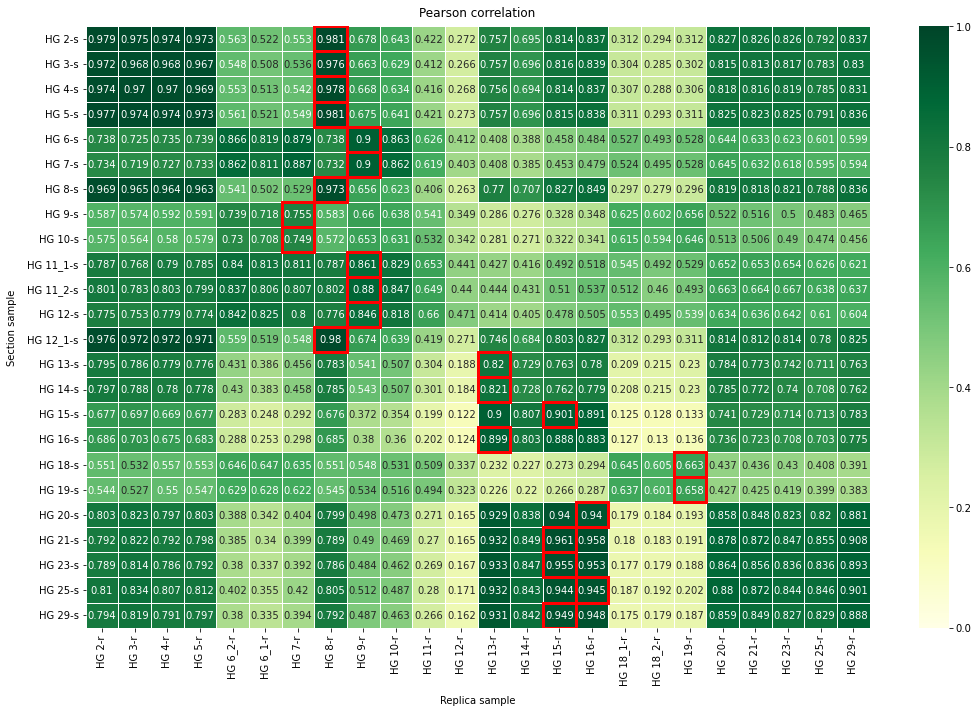

In [106]:
# Create correlation data frame
metadata_df_sort = metadata_df.sort_values(by="sample_number")
s_sample_file_name = metadata_df_sort[metadata_df_sort.sample_type ==
                                      "section"].sample_file_name
r_sample_file_name = metadata_df_sort[metadata_df_sort.sample_type ==
                                      "replica"].sample_file_name

corr_df = corr(s_sample_file_name, r_sample_file_name, non_tissue_spectras_mean,
               non_tissue_spectras_mean)

# Plot correlation data frame
ax = plot_corr(corr_df,
               title="Pearson correlation",
               x_label=f"Section sample",
               y_label=f"Replica sample")

# Mark cells of max correlation between section and replica
row_max = corr_df.idxmax(axis=1)
for row, index in enumerate(s_sample_file_name):
  position = corr_df.columns.get_loc(row_max[index])
  ax.add_patch(
      Rectangle((position, row), 1, 1, fill=False, edgecolor='red', lw=3))

# Show plot
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='sample_file_name'>

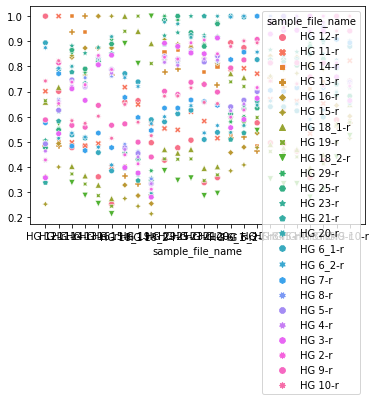

In [95]:
sns.scatterplot(data=corr_df)

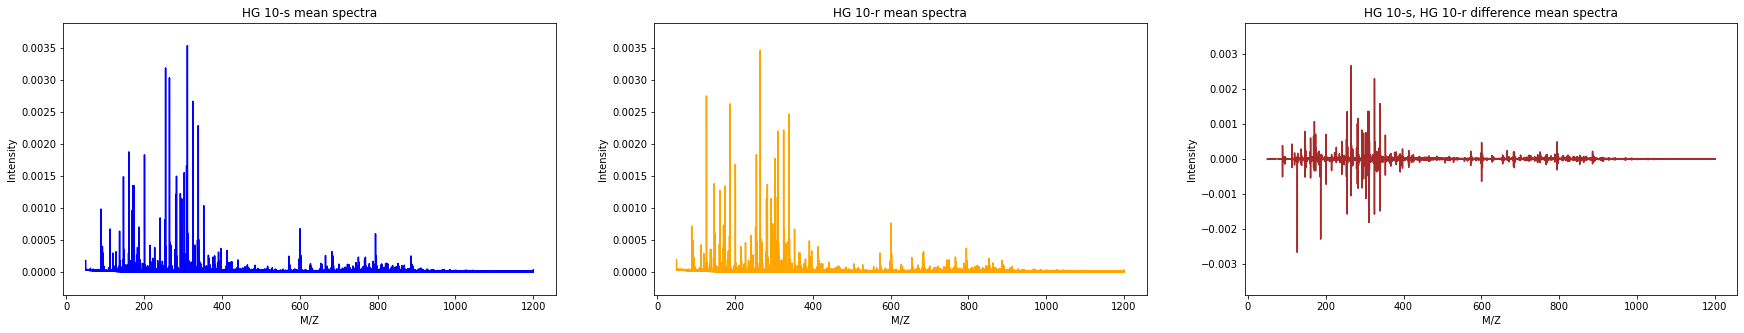

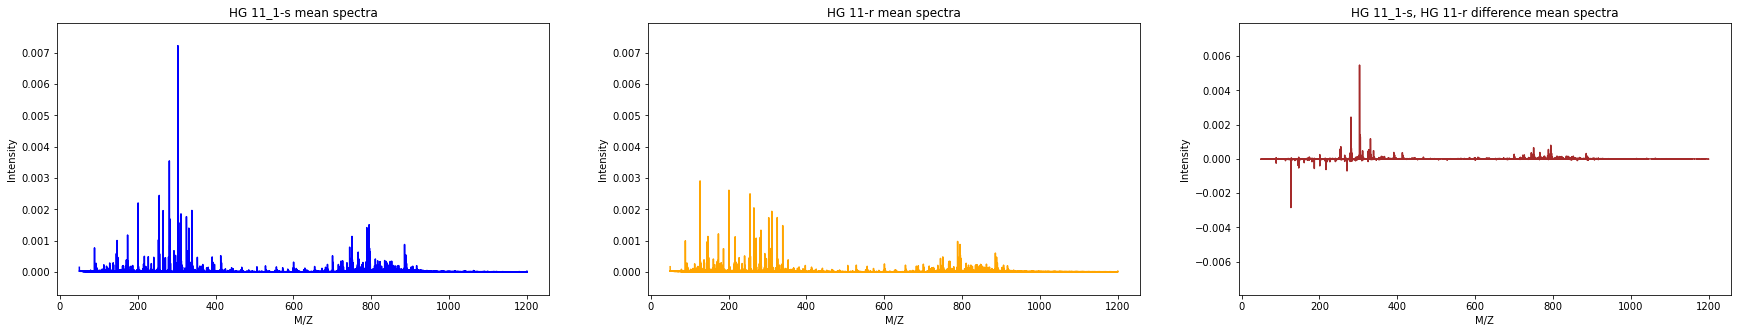

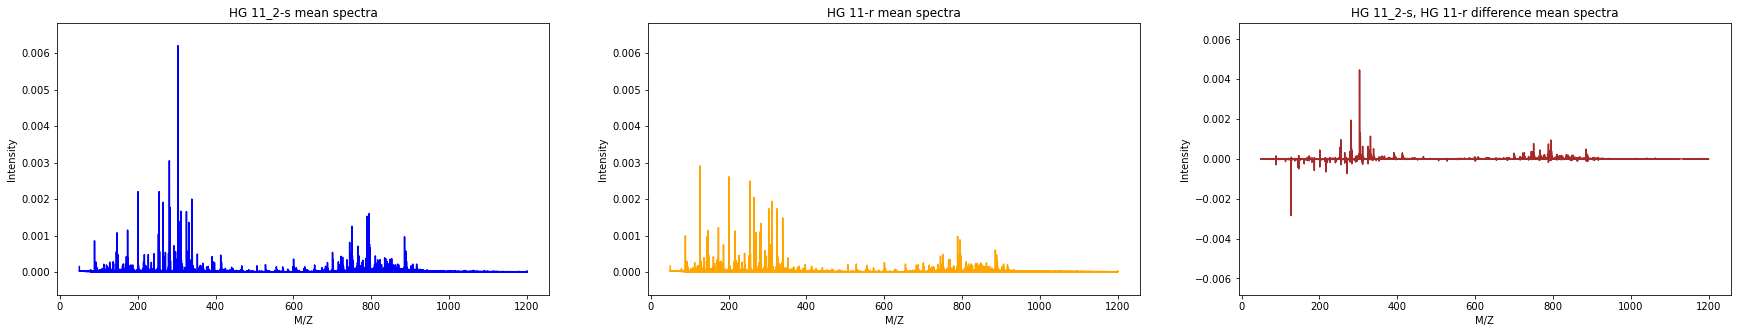

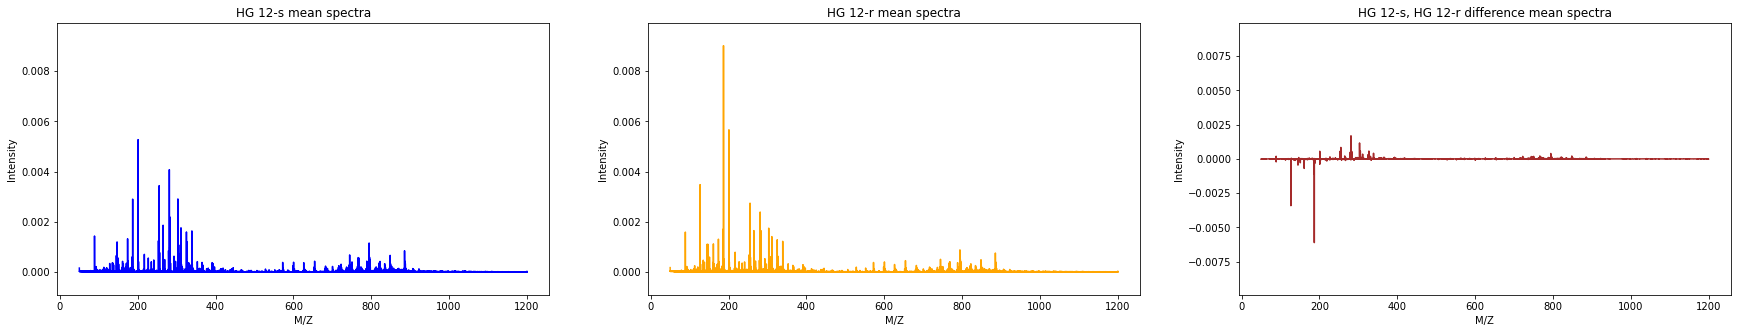

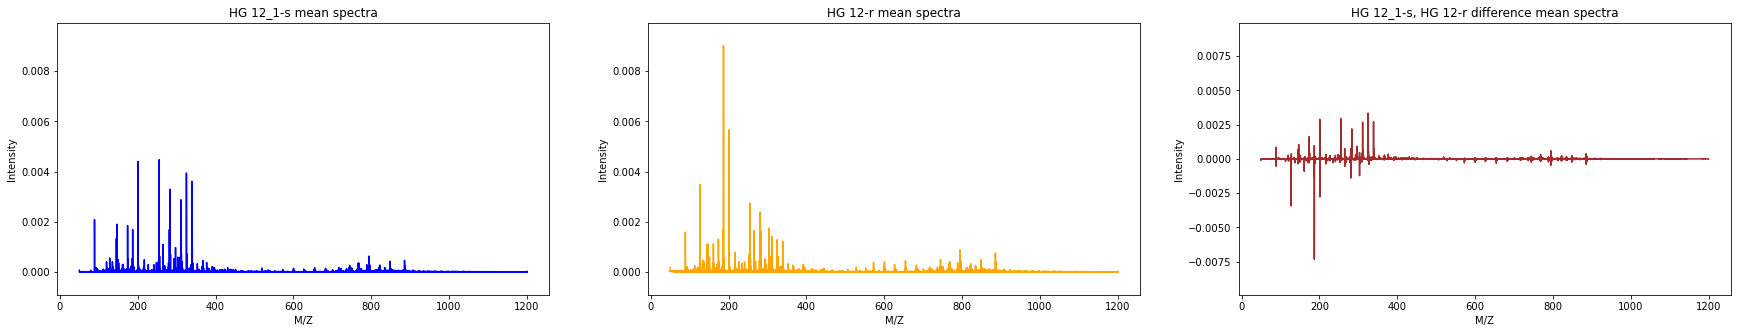

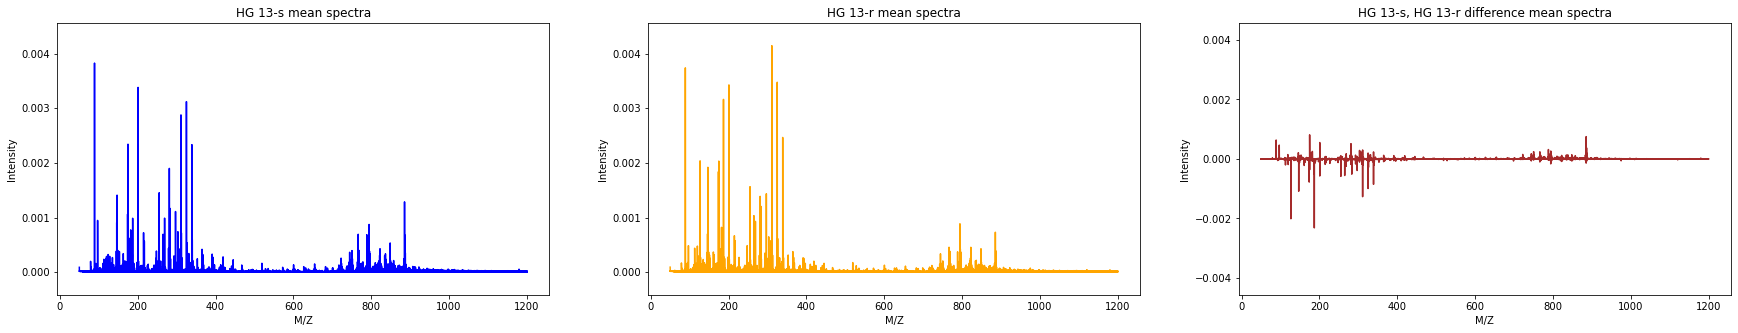

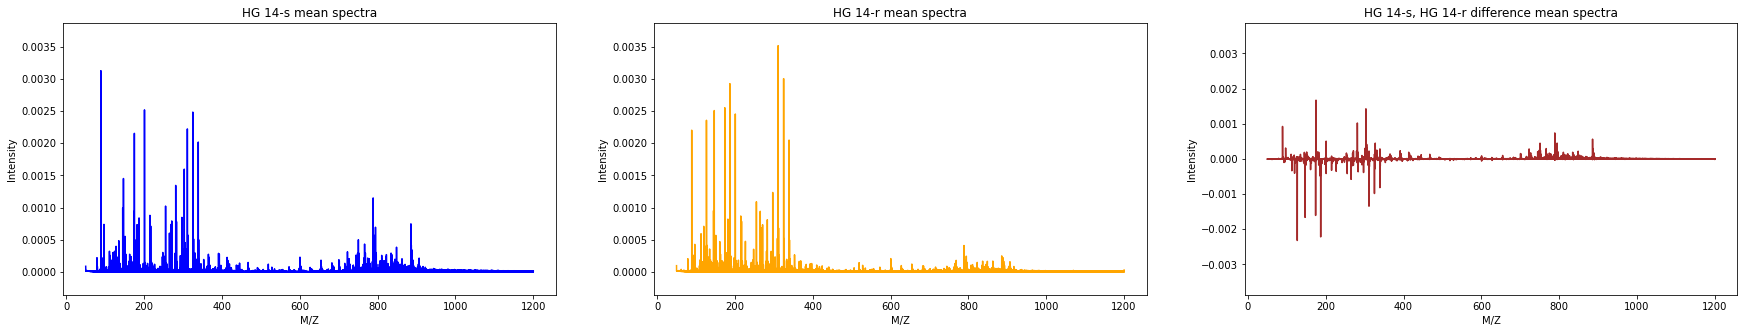

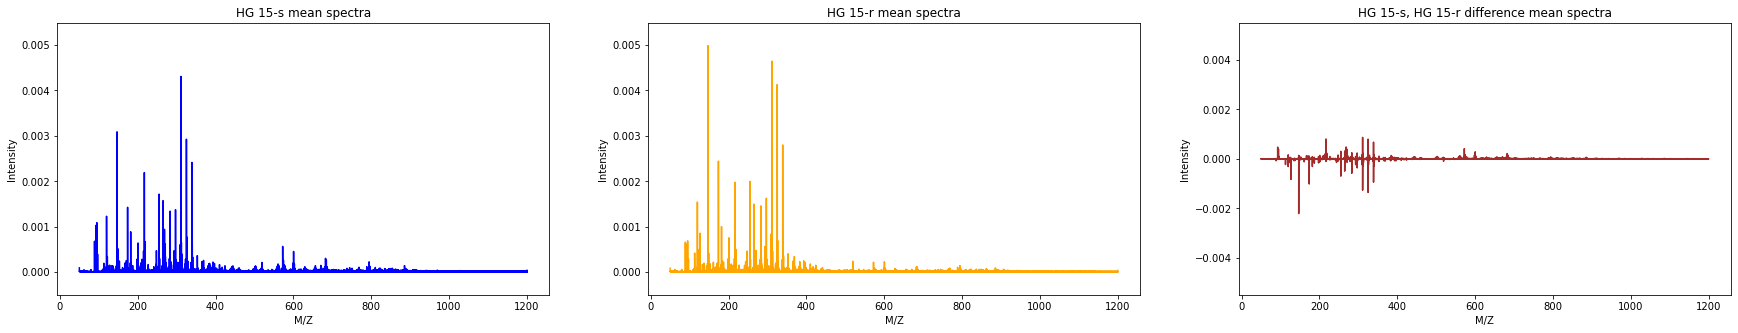

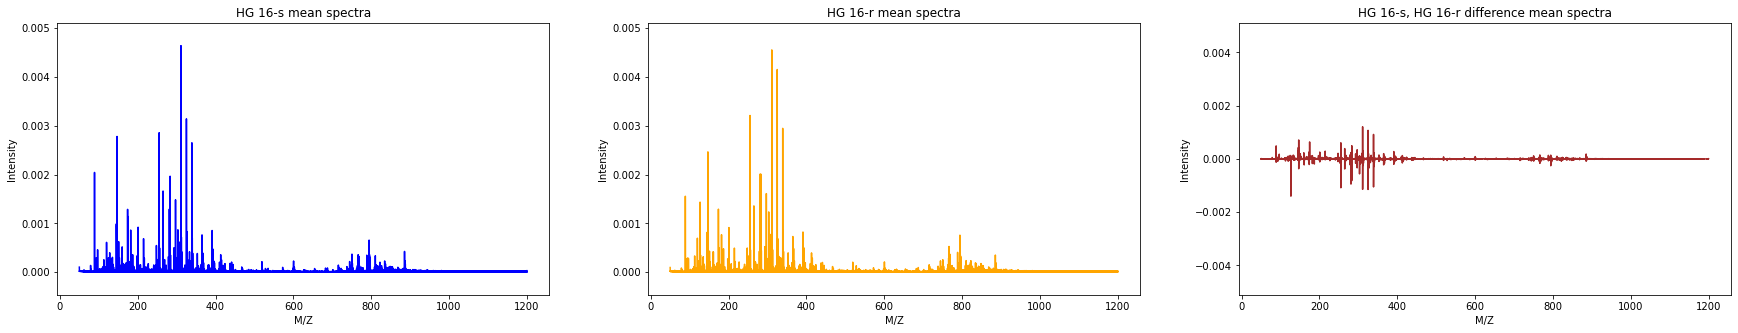

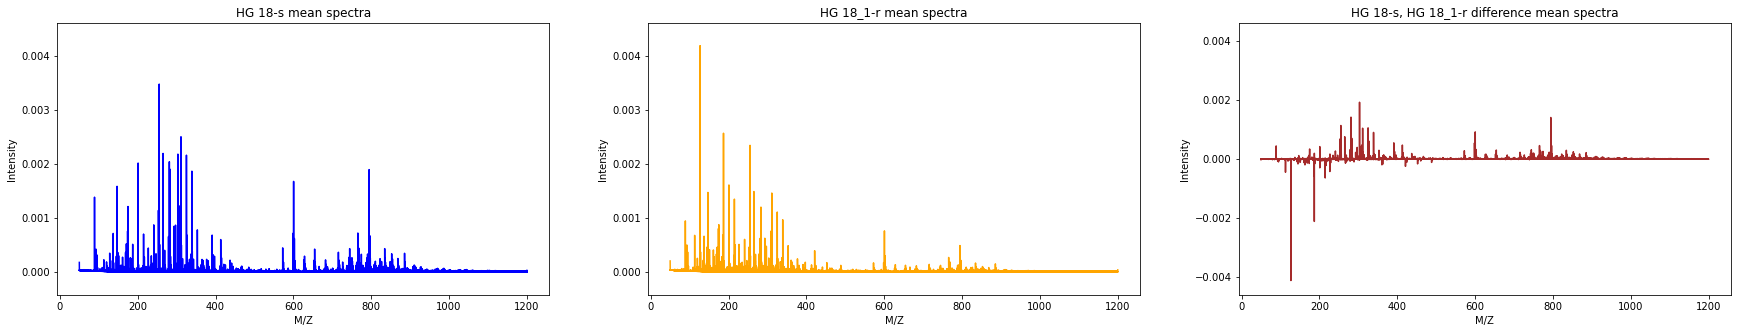

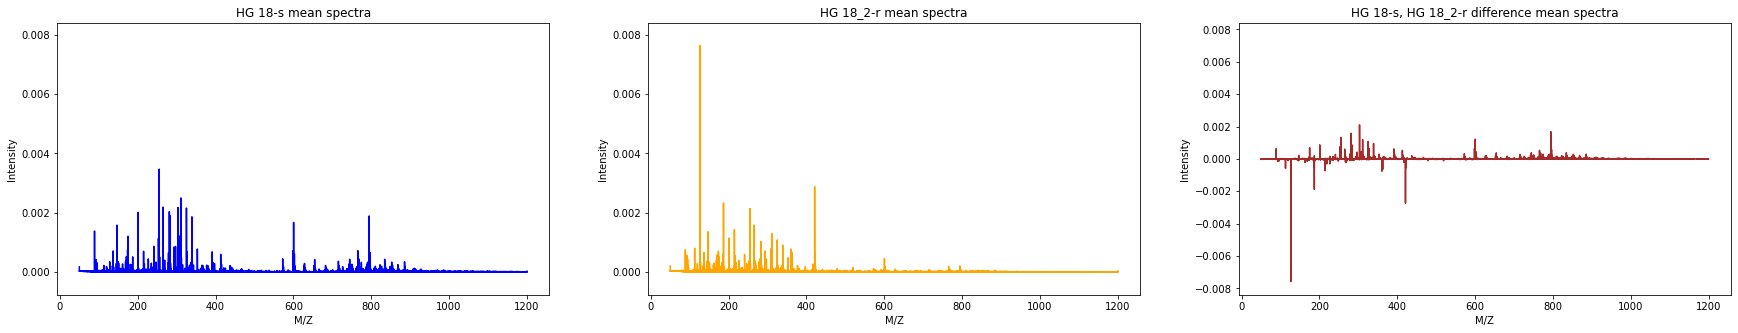

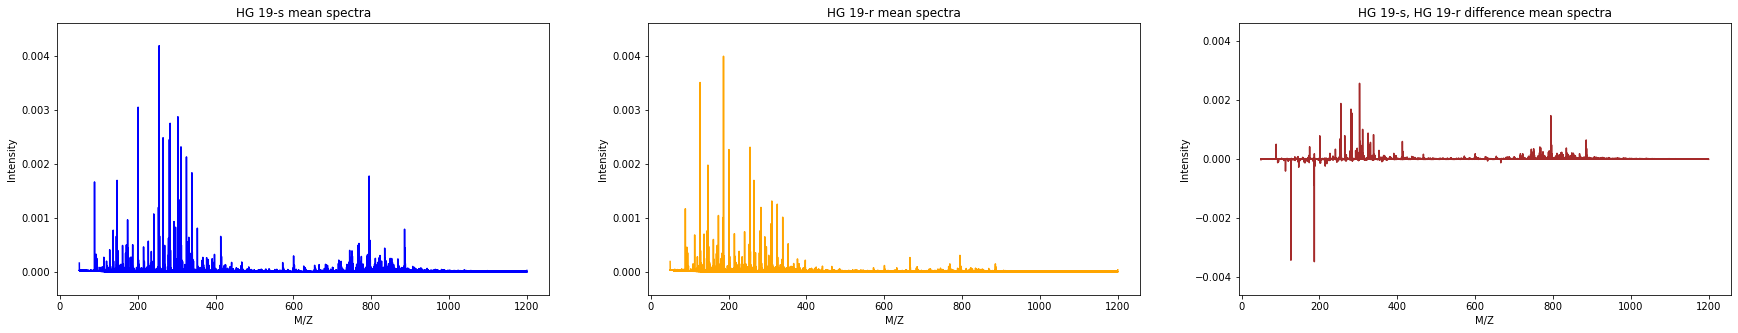

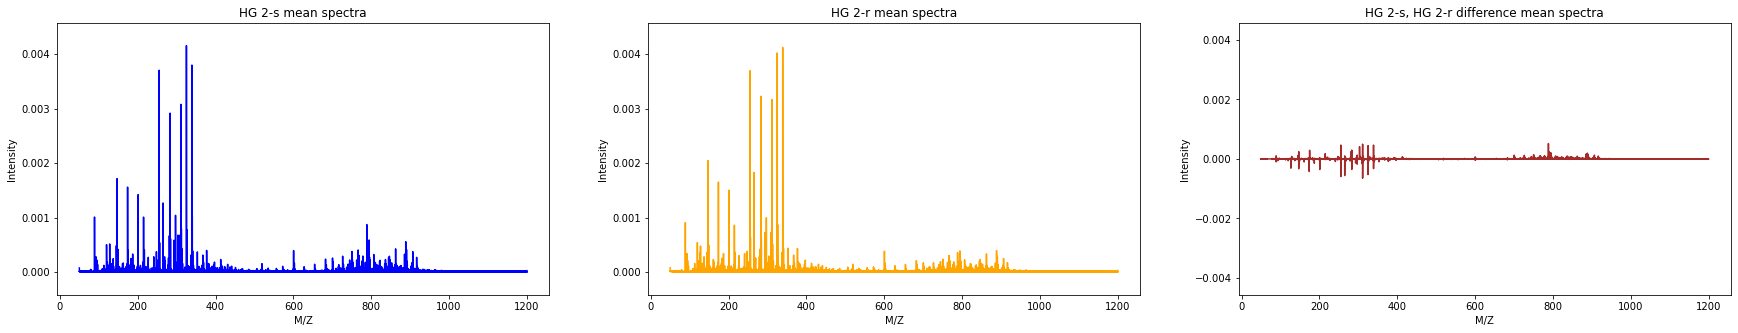

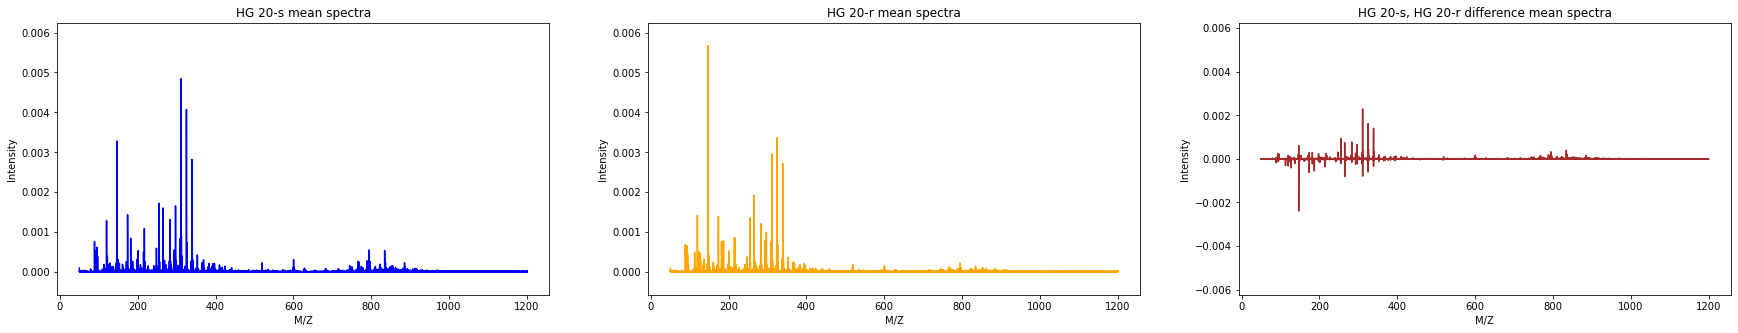

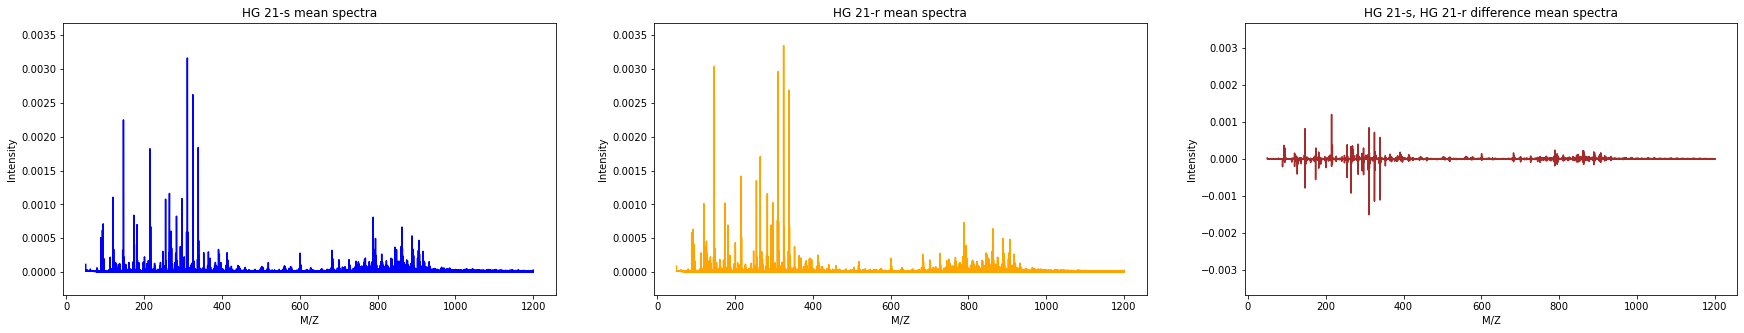

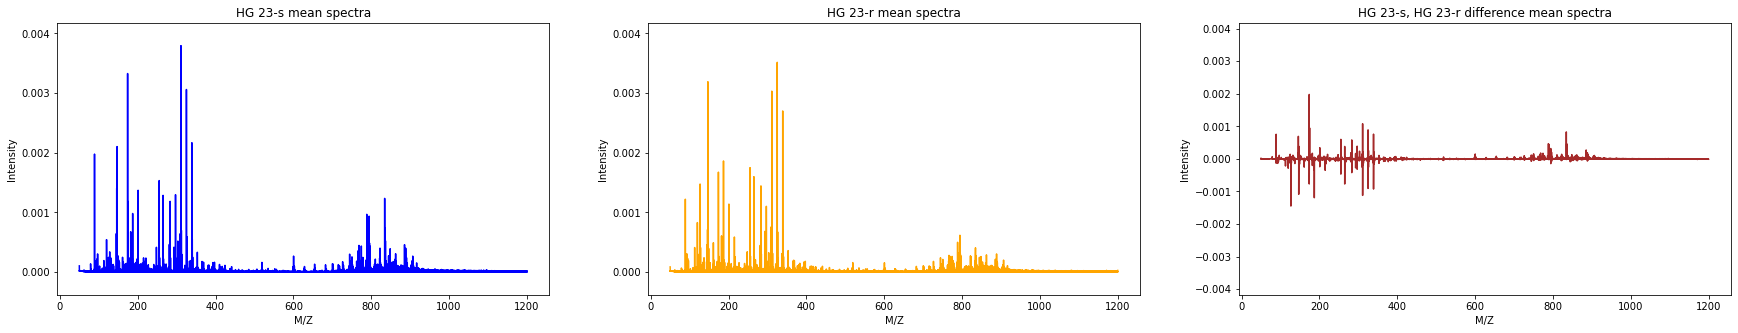

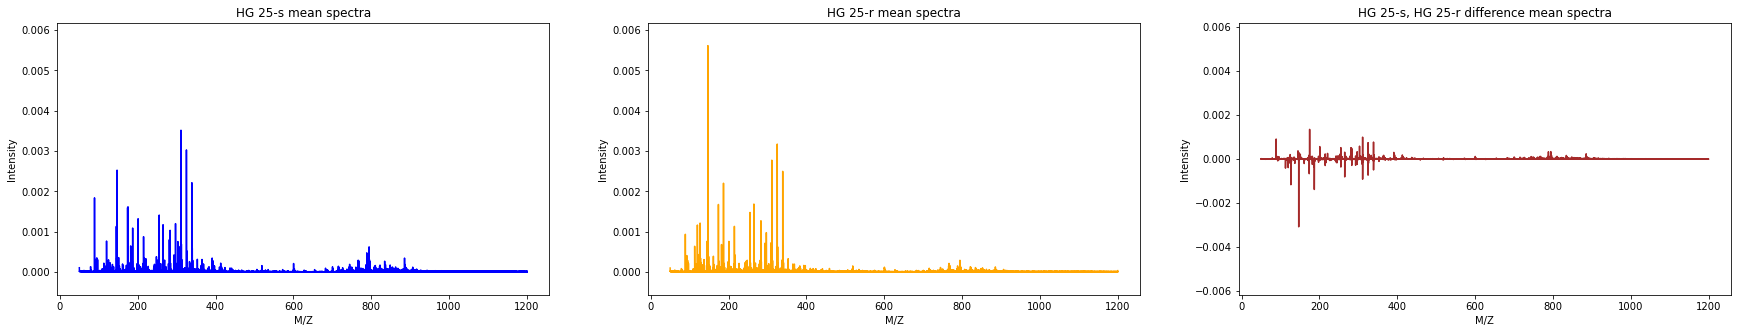

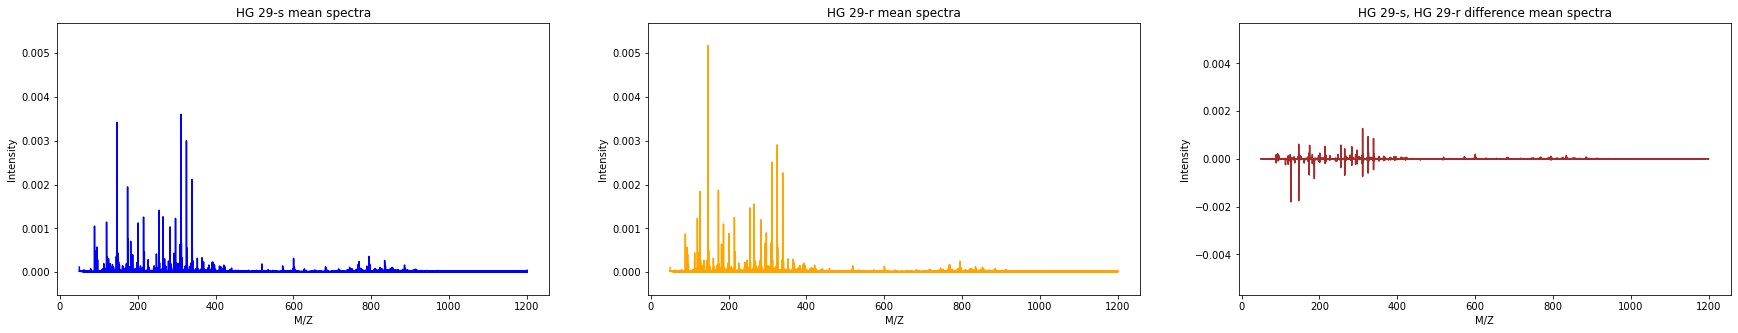

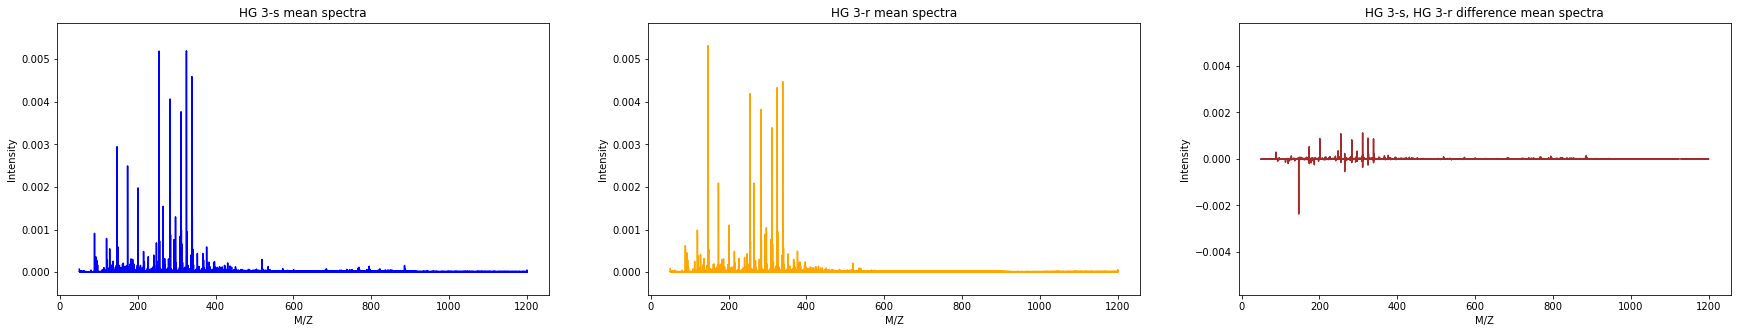

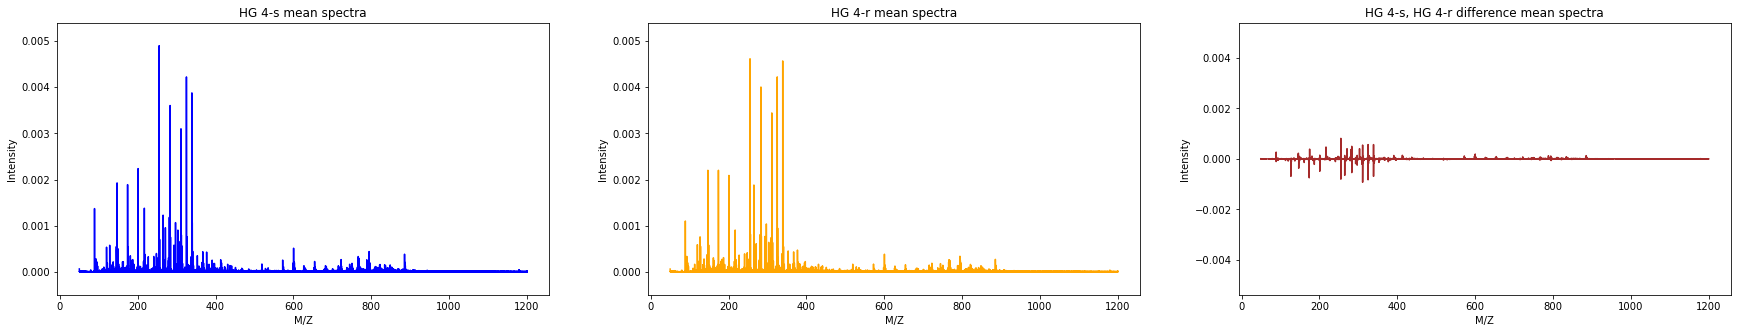

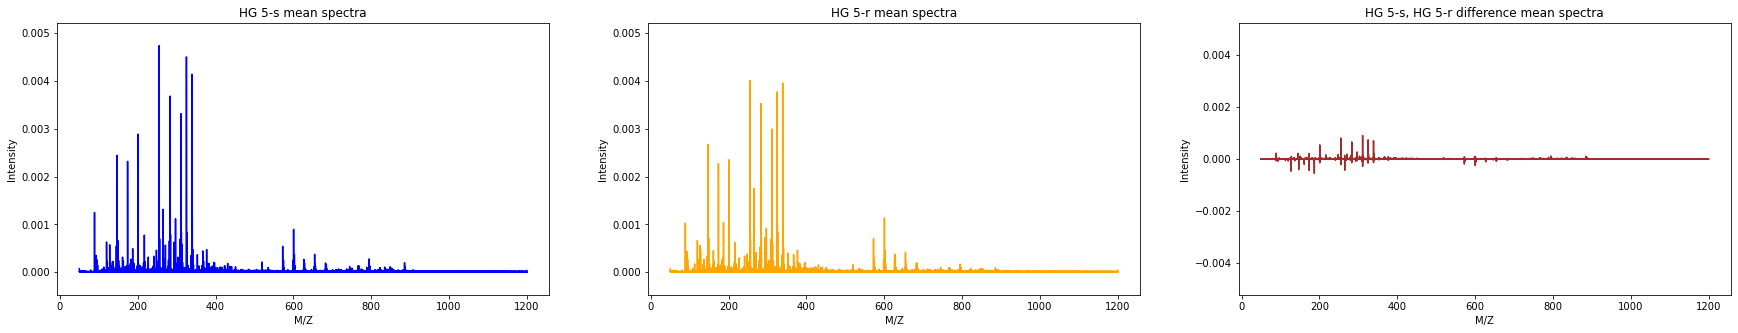

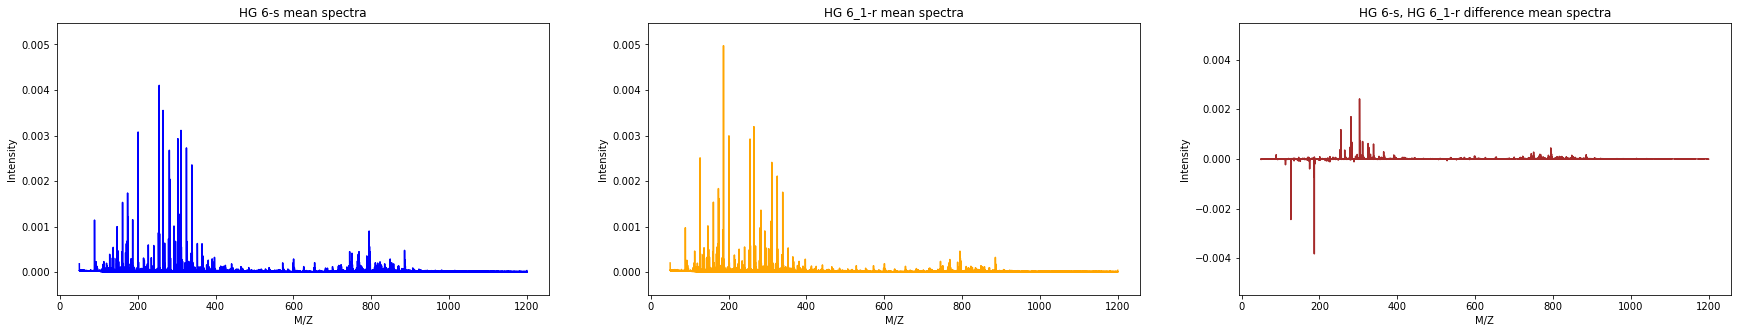

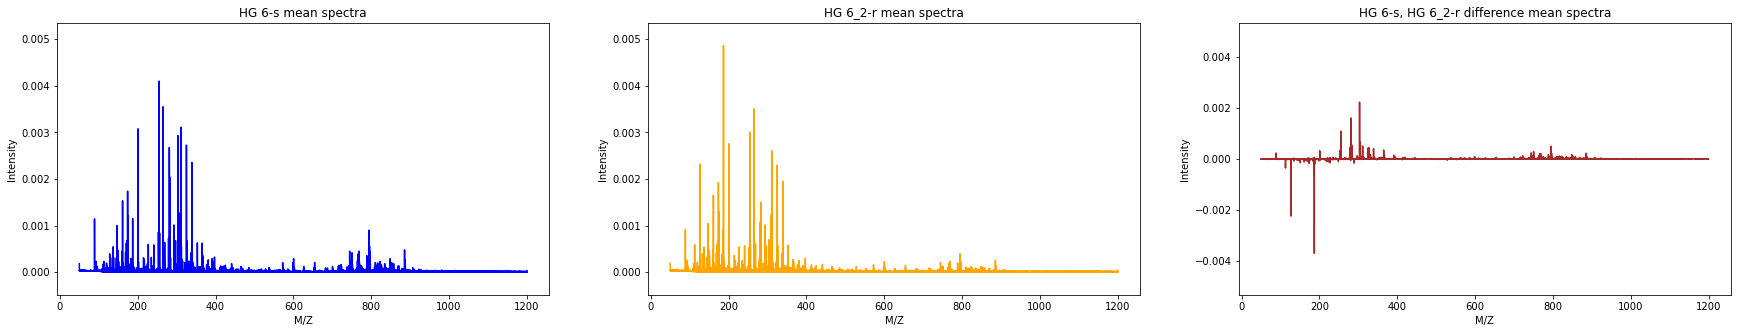

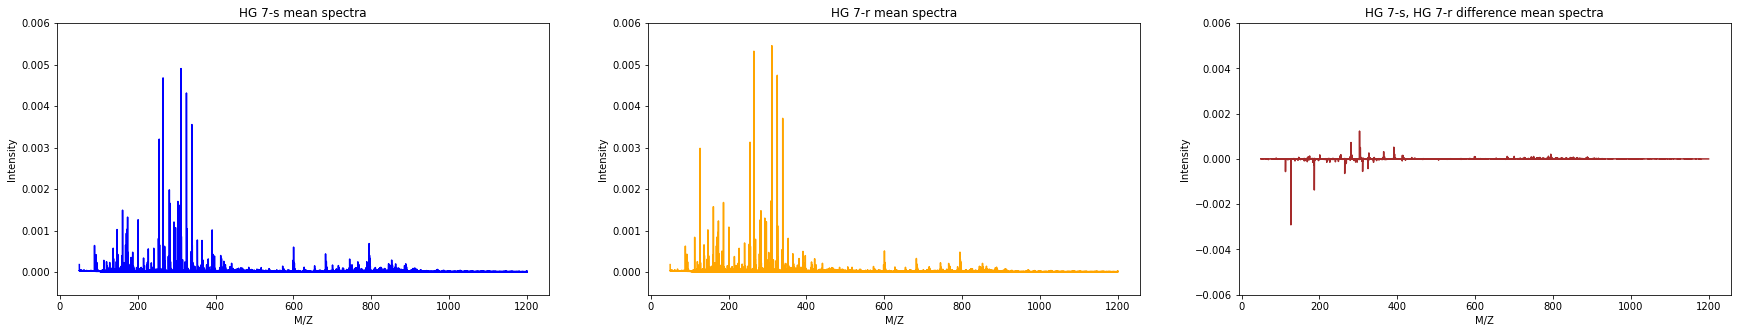

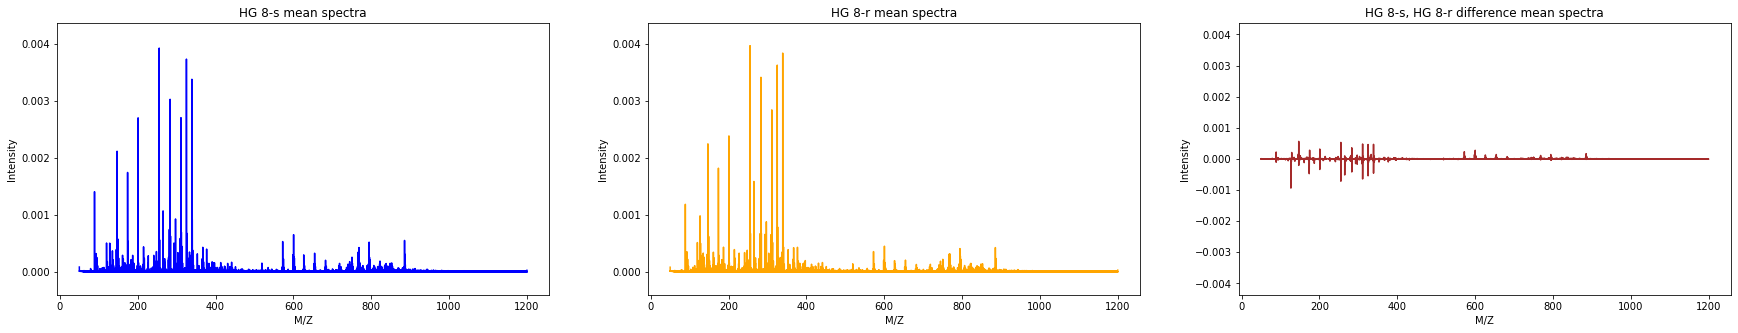

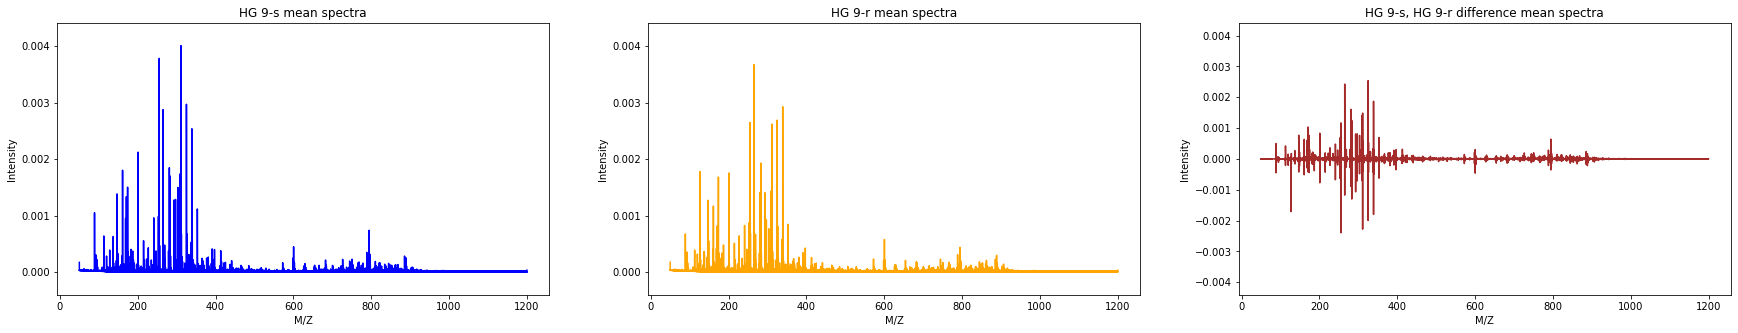

In [6]:
# Loop over each MSI
for msi_1, msi_1_mean in mean_spectras.items():
  # Check if MSI is section type and not replica
  # in order to not plot twice
  if "s" in msi_1:
    # Get MSI sample number
    msi_1_num = clinical_state_df.loc[msi_1].sample_number
    # Loop over each MSI
    for msi_2, msi_2_mean in mean_spectras.items():
      # Get MSI sample number
      msi_2_num = clinical_state_df.loc[msi_2].sample_number
      # Check if both MSI are the same sample (a replica, section pair)
      if msi_1_num == msi_2_num and msi_1 != msi_2 and 's' not in msi_2:
        # Create subplot
        fig, axes = plt.subplots(1, 3, figsize=(30, 5))
        # Get maximum intensity in order to make plot y range the same
        max_y = np.maximum(np.max(msi_1_mean), np.max(msi_2_mean))
        # Create margin for y axis in plot
        margin = 0.1 * max_y
        # Plot section msi mean spectrum
        axes[0].plot(mzs, msi_1_mean, color="Blue")
        axes[0].set_title(f"{msi_1} mean spectra")
        axes[0].set_xlabel("M/Z")
        axes[0].set_ylabel("Intensity")
        axes[0].set_ylim([-margin, max_y + margin])
        # Plot replica msi mean spectrum
        axes[1].plot(mzs, msi_2_mean, color="Orange")
        axes[1].set_title(f"{msi_2} mean spectra")
        axes[1].set_xlabel("M/Z")
        axes[1].set_ylabel("Intensity")
        axes[1].set_ylim([-margin, max_y + margin])
        # Plot section & replica msi mean spectrum difference
        axes[2].plot(mzs, msi_1_mean - msi_2_mean, color="Brown")
        axes[2].set_title(f"{msi_1}, {msi_2} difference mean spectra")
        axes[2].set_xlabel("M/Z")
        axes[2].set_ylabel("Intensity")
        axes[2].set_ylim([- (max_y + margin), max_y + margin])
        # Display plot
        plt.show()

In [7]:
# Define object to store high degree tissue spectra's sum and count
sum_spectra_high = 0
count_spectra_high = 0
# Define object to store low degree tissue spectra's sum and count
sum_spectra_low = 0
count_spectra_low = 0
# Define object to store common mz values
mzs = None

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DHG_IN_PATH, f"{index}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Get mzs ans spectra
        mzs, intensities = reader.getspectrum(idx)
        # Check if high or low degree
        if msi_row.who_grade > 2:
          # Add spectra's
          sum_spectra_high += intensities
          count_spectra_high += 1
        else:
          # Add spectra's
          sum_spectra_low += intensities
          count_spectra_low += 1

MSI Loop: 100%|██████████| 48/48 [05:05<00:00,  6.37s/it]


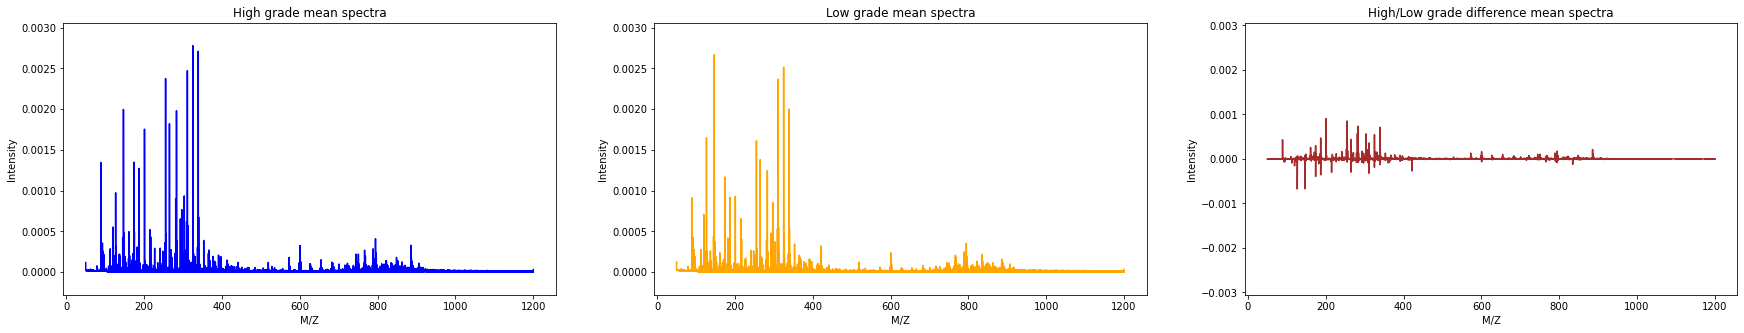

In [10]:
msi_1_mean = sum_spectra_high / count_spectra_high
msi_2_mean = sum_spectra_low / count_spectra_low

# Create subplot
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
# Get maximum intensity in order to make plot y range the same
max_y = np.maximum(np.max(msi_1_mean), np.max(msi_2_mean))
# Create margin for y axis in plot
margin = 0.1 * max_y
# Plot section msi mean spectrum
axes[0].plot(mzs, msi_1_mean, color="Blue")
axes[0].set_title("High grade mean spectra")
axes[0].set_xlabel("M/Z")
axes[0].set_ylabel("Intensity")
axes[0].set_ylim([-margin, max_y + margin])
# Plot replica msi mean spectrum
axes[1].plot(mzs, msi_2_mean, color="Orange")
axes[1].set_title(f"Low grade mean spectra")
axes[1].set_xlabel("M/Z")
axes[1].set_ylabel("Intensity")
axes[1].set_ylim([-margin, max_y + margin])
# Plot section & replica msi mean spectrum difference
axes[2].plot(mzs, msi_1_mean - msi_2_mean, color="Brown")
axes[2].set_title(f"High/Low grade difference mean spectra")
axes[2].set_xlabel("M/Z")
axes[2].set_ylabel("Intensity")
axes[2].set_ylim([- (max_y + margin), max_y + margin])
# Display plot
plt.show()

In [11]:
# Define object to store high degree tissue spectra's sum and count
sum_spectra_tissue = 0
count_spectra_tissue = 0
# Define object to store low degree tissue spectra's sum and count
sum_spectra_non_tissue = 0
count_spectra_non_tissue = 0
# Define object to store common mz values
mzs = None

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DHG_IN_PATH, f"{index}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Get mzs ans spectra
      mzs, intensities = reader.getspectrum(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        sum_spectra_tissue += intensities
        count_spectra_tissue += 1
      else:
        sum_spectra_non_tissue += intensities
        count_spectra_non_tissue += 1

MSI Loop: 100%|██████████| 48/48 [05:36<00:00,  7.00s/it]


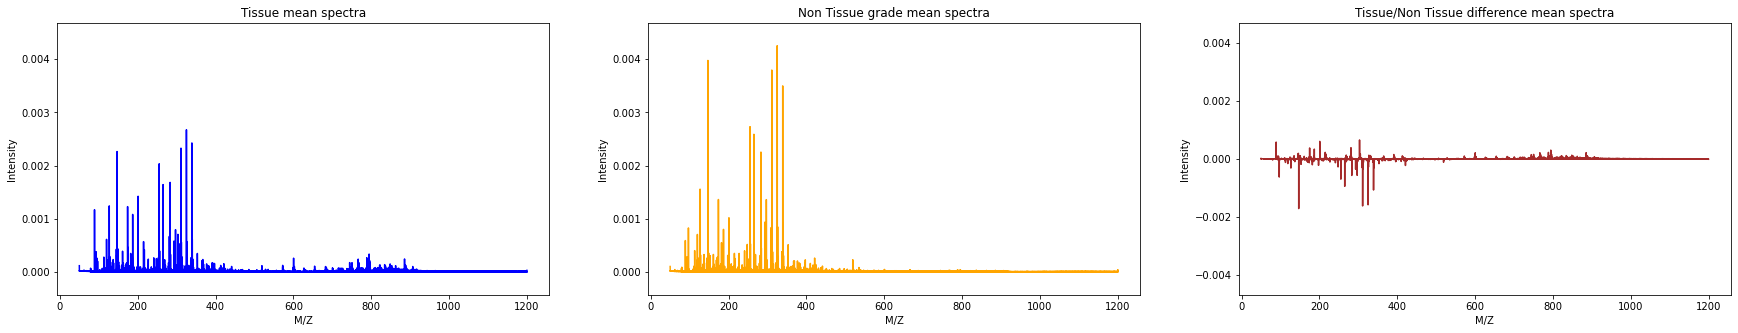

In [13]:
msi_1_mean = sum_spectra_tissue / count_spectra_tissue
msi_2_mean = sum_spectra_non_tissue / count_spectra_non_tissue

# Create subplot
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
# Get maximum intensity in order to make plot y range the same
max_y = np.maximum(np.max(msi_1_mean), np.max(msi_2_mean))
# Create margin for y axis in plot
margin = 0.1 * max_y
# Plot section msi mean spectrum
axes[0].plot(mzs, msi_1_mean, color="Blue")
axes[0].set_title("Tissue mean spectra")
axes[0].set_xlabel("M/Z")
axes[0].set_ylabel("Intensity")
axes[0].set_ylim([-margin, max_y + margin])
# Plot replica msi mean spectrum
axes[1].plot(mzs, msi_2_mean, color="Orange")
axes[1].set_title(f"Non Tissue mean spectra")
axes[1].set_xlabel("M/Z")
axes[1].set_ylabel("Intensity")
axes[1].set_ylim([-margin, max_y + margin])
# Plot section & replica msi mean spectrum difference
axes[2].plot(mzs, msi_1_mean - msi_2_mean, color="Brown")
axes[2].set_title(f"Tissue/Non Tissue difference mean spectra")
axes[2].set_xlabel("M/Z")
axes[2].set_ylabel("Intensity")
axes[2].set_ylim([- (max_y + margin), max_y + margin])
# Display plot
plt.show()